<a href="https://colab.research.google.com/github/vorst4/TUE_5LSM0_g6/blob/master/TUE_5LSM0_g6_dennis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:

# ------------------------------ Import modules ------------------------------ #

import os
import sys
import json
import pickle
import importlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from glob import glob
from datetime import datetime
from PIL import Image
from google.colab import drive
import matplotlib.pyplot as plt

try:
  import rdp
except:
  !pip install rdp
  import rdp

# --------------------------------- Constants -------------------------------- #

N_classes = 9
N_train = 22799
N_val = 2532
N_test = 8238


# ---------------------- Import modules from Git source ---------------------- #

# efficient net
try:
  from src.efficientnet.efficientnet_pytorch.model import EfficientNet
except:
  print('\nInstalling efficient-net...')
  !pip install -e git+https://github.com/lukemelas/EfficientNet-PyTorch#egg=EfficientNet
  from src.efficientnet.efficientnet_pytorch.model import EfficientNet
  print('Done')



# ----------------------------- Initialize Colab ----------------------------- #
#
# NOTE: all console commands (the ones that start with !) cannot be run from a 
# .py script. Usually this is possible using the command 'os.system('...')'.
# However, in Colab, it is for some reason not possible to obtain the console
# output of the command that is run. This makes it impossible to notify the user
# if an error occurs. All the commands therefore need to be run in the main
# .ipynb script (which is this script).
#


# check if GPU is enabled
if torch.cuda.is_available() == False:
  print('\nWARNING: GPU not enabled. Goto runtime -> change runtime type')


# mount Google Drive (if needed)
if not os.path.exists('drive'):
  print('\nMounting Google Drive...')
  drive.mount('/content/drive')
  print('Done')


# setup Git (if needed)
if not os.path.exists('TUE_5LSM0_g6'):
  print('\nSetting up git...')
  print('...Loading github.json from Google Drive')
  with open('/content/drive/My Drive/github.json', 'r') as json_file:
    gitconfig = json.load(json_file)
  print('...Cloning git repo')
  url = 'https://'+gitconfig["username"]+':'+gitconfig["key"]+\
        '@github.com/vorst4/TUE_5LSM0_g6.git'
  !git clone {url}
  print('...Setting username and email')
  !git -C TUE_5LSM0_g6 config user.name {gitconfig["username"]}
  !git -C TUE_5LSM0_g6 config user.email {gitconfig["email"]}
  print('Done')


# remove default sample_data folder (if needed)
if os.path.exists('sample_data'):
  print('\nRemoving sample_data...')
  os.system('rm -r sample_data')
  print('Done')


# copy and unzip data from Google Drive (if needed)
if not os.path.exists('ISIC_2019_Test_Input'):
  print('\nGetting data...')
  print('...Copying data.zip from Google Drive to workfolder')
  !cp 'drive/My Drive/5LSM0-final-assignment/data.zip' .
  print('...Unpacking data.zip')
  !unzip -q data.zip
  print('...Removing data.zip')
  !rm data.zip
  print('Done\n')


# ----------------------------- Import Functions ----------------------------- #
#
# NOTE: The modules need to be forcibly reloaded because Colab does not do this
# by default, even if the module has changed.
#

# append git dir to systems paths
sys.path.append('TUE_5LSM0_g6')

# dataloaders
import dataloaders_augmentation
importlib.reload(dataloaders_augmentation)
dataloaders_augmentation = dataloaders_augmentation.dataloaders

# train & accuracy
import train2
importlib.reload(train2)

# resnet18
import resnet18
importlib.reload(resnet18)
resnet18 = resnet18.resnet18

# restore
import restore2
importlib.reload(restore2)
restore2 = restore2.restore2

# score
import score
importlib.reload(score)
Score = score.Score

# cam
import class_activation_map as cam
importlib.reload(cam)

# isic_challenge_scoring
import isic_challenge_scoring
from isic_challenge_scoring.classification import ClassificationScore


# --------------------------------- Settings --------------------------------- #

# settings object
S = type('Settings', (), {})()

# use gpu/cpu
if torch.cuda.is_available():
  S.device = torch.device('cuda')
else:
  S.device = torch.device('cpu')

# image size (squared)
S.modelname = 'efficientnet-b0'
S.img_size = EfficientNet.get_image_size(S.modelname)

# set variable type
S.dtype = torch.float32

# when to print
S.evaluate_every = 200

# number of epochs to run
S.epochs = 50

# batch size, increase this until the RAM is full
S.batch_size = 32

# restore last backup of model?
S.load_backup = True

# Create backup each epoch?
S.backup_each_epoch = True


# model parameters
model_params = {
  'batch_norm_momentum': 0.99,
  'batch_norm_epsilon': 1e-3,
  'dropout_rate': 0.1,
  'drop_connect_rate': 0.1,
  'num_classes': N_classes }

# learning rate (with decay)
learning_rate = 1e-5
decayRate = 0.99


# ----------------------------------- Main ----------------------------------- #

# create data loader objects
dl_train, dl_val, dl_test = dataloaders_augmentation(batch_size=S.batch_size,
                                        img_size = S.img_size)

# create model
model = EfficientNet.from_name(S.modelname, model_params)

# link data loaders to model
model_hyperparam = type('HyperParameters', (), {})()
model_hyperparam.dl_train = dl_train
model_hyperparam.dl_val = dl_val
model_hyperparam.dl_test = dl_test

# load backup (if required)
if S.load_backup:
  model, model_data = restore2(model, S.modelname)
else:
  model_data = {}

# create score
model_hyperparam.score = Score(model, model_hyperparam)

# define optimizer
model_hyperparam.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# learning rate
model_hyperparam.lr_exp = optim.lr_scheduler.ExponentialLR(optimizer=model_hyperparam.optimizer, gamma=decayRate)

# # train
train2.Train(model, model_hyperparam, model_data, S)

# create csv file of test data
make_cvs2(model, dl_test, S.modelname)


# ----------------------------------- End ------------------------------------ #



Restored model


Estimated number of iterations per epoch: 713

Epoch 64/113  print 1/4  t_elaps.00h00m21s  t_rem.06h28m00s  loss 0.5647  bma 0.545  
    ak      31/87       bcc    283/332      bkl     76/262      df       5/24       
    mel    289/452      nv     986/1287     scc     12/63       vasc    15/25       
Epoch 64/113  print 2/4  t_elaps.00h02m04s  t_rem.06h19m59s  loss 0.9497  bma 0.549  
    ak      30/87       bcc    291/332      bkl     77/262      df       6/24       
    mel    292/452      nv     974/1287     scc     11/63       vasc    15/25       
Epoch 64/113  print 3/4  t_elaps.00h03m47s  t_rem.05h46m24s  loss 0.7666  bma 0.553  
    ak      32/87       bcc    287/332      bkl     79/262      df       5/24       
    mel    293/452      nv     976/1287     scc     12/63       vasc    16/25       
Epoch 64/113  print 4/4  t_elaps.00h05m29s  t_rem.05h33m19s  loss 0.6939  bma 0.552  
    ak      30/87       bcc    277/332      bkl     79/262      df       5/24    

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



 new lr =  [9.801e-06]
Epoch 65/113  print 1/4  t_elaps.00h06m36s  t_rem.05h37m07s  loss 0.6296  bma 0.546  
    ak      30/87       bcc    281/332      bkl     74/262      df       5/24       
    mel    295/452      nv     984/1287     scc     11/63       vasc    16/25       
Epoch 65/113  print 2/4  t_elaps.00h08m18s  t_rem.05h29m18s  loss 0.5305  bma 0.552  
    ak      30/87       bcc    281/332      bkl     77/262      df       5/24       
    mel    298/452      nv     979/1287     scc     11/63       vasc    17/25       
Epoch 65/113  print 3/4  t_elaps.00h10m00s  t_rem.05h23m22s  loss 0.8478  bma 0.554  
    ak      33/87       bcc    284/332      bkl     75/262      df       5/24       
    mel    299/452      nv     981/1287     scc     12/63       vasc    16/25       
Epoch 65/113  print 4/4  t_elaps.00h11m41s  t_rem.05h18m31s  loss 0.7018  bma 0.549  
    ak      32/87       bcc    279/332      bkl     77/262      df       5/24       
    mel    294/452      nv     984/12

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



 new lr =  [9.70299e-06]
Epoch 66/113  print 1/4  t_elaps.00h12m47s  t_rem.05h20m01s  loss 0.7835  bma 0.550  
    ak      31/87       bcc    282/332      bkl     83/262      df       5/24       
    mel    294/452      nv     975/1287     scc     11/63       vasc    16/25       
Epoch 66/113  print 2/4  t_elaps.00h14m28s  t_rem.05h15m45s  loss 0.7987  bma 0.550  
    ak      33/87       bcc    287/332      bkl     80/262      df       5/24       
    mel    293/452      nv     974/1287     scc     12/63       vasc    15/25       
Epoch 66/113  print 3/4  t_elaps.00h16m10s  t_rem.05h12m17s  loss 0.6014  bma 0.555  
    ak      31/87       bcc    280/332      bkl     78/262      df       6/24       
    mel    298/452      nv     979/1287     scc     12/63       vasc    16/25       
Epoch 66/113  print 4/4  t_elaps.00h17m51s  t_rem.05h09m11s  loss 0.6364  bma 0.550  
    ak      28/87       bcc    287/332      bkl     73/262      df       6/24       
    mel    298/452      nv     981/

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



 new lr =  [9.6059601e-06]
Epoch 67/113  print 1/4  t_elaps.00h18m58s  t_rem.05h10m08s  loss 0.7973  bma 0.544  
    ak      32/87       bcc    284/332      bkl     70/262      df       5/24       
    mel    297/452      nv     982/1287     scc     11/63       vasc    15/25       
Epoch 67/113  print 2/4  t_elaps.00h20m40s  t_rem.05h07m09s  loss 1.1694  bma 0.552  
    ak      33/87       bcc    285/332      bkl     76/262      df       6/24       
    mel    299/452      nv     969/1287     scc     11/63       vasc    15/25       
Epoch 67/113  print 3/4  t_elaps.00h22m21s  t_rem.05h04m16s  loss 0.4466  bma 0.548  
    ak      32/87       bcc    280/332      bkl     79/262      df       5/24       
    mel    299/452      nv     977/1287     scc     12/63       vasc    15/25       
Epoch 67/113  print 4/4  t_elaps.00h24m02s  t_rem.05h01m30s  loss 0.8419  bma 0.556  
    ak      31/87       bcc    280/332      bkl     79/262      df       6/24       
    mel    294/452      nv     98

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



 new lr =  [9.509900499e-06]
Epoch 68/113  print 1/4  t_elaps.00h25m09s  t_rem.05h02m00s  loss 1.1763  bma 0.559  
    ak      31/87       bcc    291/332      bkl     70/262      df       6/24       
    mel    289/452      nv     989/1287     scc     12/63       vasc    17/25       
Epoch 68/113  print 2/4  t_elaps.00h26m51s  t_rem.04h59m29s  loss 0.5455  bma 0.556  
    ak      33/87       bcc    286/332      bkl     75/262      df       6/24       
    mel    296/452      nv     976/1287     scc     11/63       vasc    16/25       
Epoch 68/113  print 3/4  t_elaps.00h28m33s  t_rem.04h57m07s  loss 0.5773  bma 0.557  
    ak      32/87       bcc    281/332      bkl     78/262      df       6/24       
    mel    294/452      nv     986/1287     scc     12/63       vasc    16/25       
Epoch 68/113  print 4/4  t_elaps.00h30m14s  t_rem.04h54m45s  loss 0.7541  bma 0.555  
    ak      31/87       bcc    285/332      bkl     77/262      df       6/24       
    mel    289/452      nv     

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



 new lr =  [9.414801494009999e-06]
Epoch 69/113  print 1/4  t_elaps.00h31m21s  t_rem.04h54m54s  loss 0.6389  bma 0.551  
    ak      32/87       bcc    283/332      bkl     79/262      df       6/24       
    mel    299/452      nv     972/1287     scc     11/63       vasc    15/25       
Epoch 69/113  print 2/4  t_elaps.00h33m02s  t_rem.04h52m29s  loss 0.8016  bma 0.552  
    ak      31/87       bcc    281/332      bkl     85/262      df       6/24       
    mel    299/452      nv     971/1287     scc     11/63       vasc    15/25       
Epoch 69/113  print 3/4  t_elaps.00h34m44s  t_rem.04h50m15s  loss 0.6874  bma 0.547  
    ak      33/87       bcc    284/332      bkl     78/262      df       5/24       
    mel    292/452      nv     978/1287     scc     11/63       vasc    15/25       
Epoch 69/113  print 4/4  t_elaps.00h36m25s  t_rem.04h48m03s  loss 0.5885  bma 0.556  
    ak      33/87       bcc    286/332      bkl     75/262      df       6/24       
    mel    297/452      n

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



 new lr =  [9.320653479069899e-06]
Epoch 70/113  print 1/4  t_elaps.00h37m32s  t_rem.04h48m02s  loss 0.6940  bma 0.548  
    ak      30/87       bcc    290/332      bkl     71/262      df       6/24       
    mel    300/452      nv     972/1287     scc     11/63       vasc    15/25       
Epoch 70/113  print 2/4  t_elaps.00h39m15s  t_rem.04h45m57s  loss 0.8308  bma 0.554  
    ak      34/87       bcc    285/332      bkl     78/262      df       6/24       
    mel    298/452      nv     969/1287     scc     11/63       vasc    15/25       
Epoch 70/113  print 3/4  t_elaps.00h40m57s  t_rem.04h43m50s  loss 0.9019  bma 0.553  
    ak      32/87       bcc    289/332      bkl     80/262      df       6/24       
    mel    300/452      nv     963/1287     scc     11/63       vasc    15/25       
Epoch 70/113  print 4/4  t_elaps.00h42m39s  t_rem.04h41m46s  loss 0.7475  bma 0.557  
    ak      31/87       bcc    285/332      bkl     69/262      df       6/24       
    mel    305/452      n

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



 new lr =  [9.227446944279199e-06]
Epoch 71/113  print 1/4  t_elaps.00h43m46s  t_rem.04h41m37s  loss 0.6971  bma 0.560  
    ak      31/87       bcc    282/332      bkl     81/262      df       6/24       
    mel    295/452      nv     988/1287     scc     11/63       vasc    17/25       
Epoch 71/113  print 2/4  t_elaps.00h45m28s  t_rem.04h39m32s  loss 0.9081  bma 0.554  
    ak      31/87       bcc    286/332      bkl     74/262      df       6/24       
    mel    295/452      nv     985/1287     scc     11/63       vasc    16/25       
Epoch 71/113  print 3/4  t_elaps.00h47m10s  t_rem.04h37m26s  loss 0.7983  bma 0.553  
    ak      33/87       bcc    282/332      bkl     69/262      df       7/24       
    mel    298/452      nv     981/1287     scc     11/63       vasc    15/25       
Epoch 71/113  print 4/4  t_elaps.00h48m52s  t_rem.04h35m24s  loss 0.6625  bma 0.555  
    ak      34/87       bcc    284/332      bkl     80/262      df       6/24       
    mel    300/452      n

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



 new lr =  [9.135172474836406e-06]
Epoch 72/113  print 1/4  t_elaps.00h49m59s  t_rem.04h35m08s  loss 0.4601  bma 0.548  
    ak      31/87       bcc    286/332      bkl     83/262      df       5/24       
    mel    294/452      nv     982/1287     scc     11/63       vasc    15/25       
Epoch 72/113  print 2/4  t_elaps.00h51m40s  t_rem.04h33m03s  loss 0.5953  bma 0.545  
    ak      28/87       bcc    287/332      bkl     84/262      df       5/24       
    mel    296/452      nv     978/1287     scc     11/63       vasc    15/25       
Epoch 72/113  print 3/4  t_elaps.00h53m21s  t_rem.04h30m58s  loss 1.0897  bma 0.557  
    ak      32/87       bcc    283/332      bkl     88/262      df       6/24       
    mel    302/452      nv     969/1287     scc     12/63       vasc    15/25       
Epoch 72/113  print 4/4  t_elaps.00h55m03s  t_rem.04h28m56s  loss 0.6313  bma 0.554  
    ak      32/87       bcc    287/332      bkl     82/262      df       6/24       
    mel    296/452      n

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



 new lr =  [9.043820750088042e-06]


KeyboardInterrupt: ignored

In [0]:
# ------------------------- GIT Pull, Commit & Push -------------------------- #

def git():

  if not input('\nPull? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 pull

  commit_msg = '\''+input('\nEnter commit message: ')+'\''

  if not input('\nCommit? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 add .
  !git -C /content/TUE_5LSM0_g6 commit -m {commit_msg}

  if not input('\nPush? (y)') == 'y':
    return
  !git -C /content/TUE_5LSM0_g6 push

git()

# ----------------------------------- End ------------------------------------ #


Generated heatmap of random image. heatmap bkl is the correct one


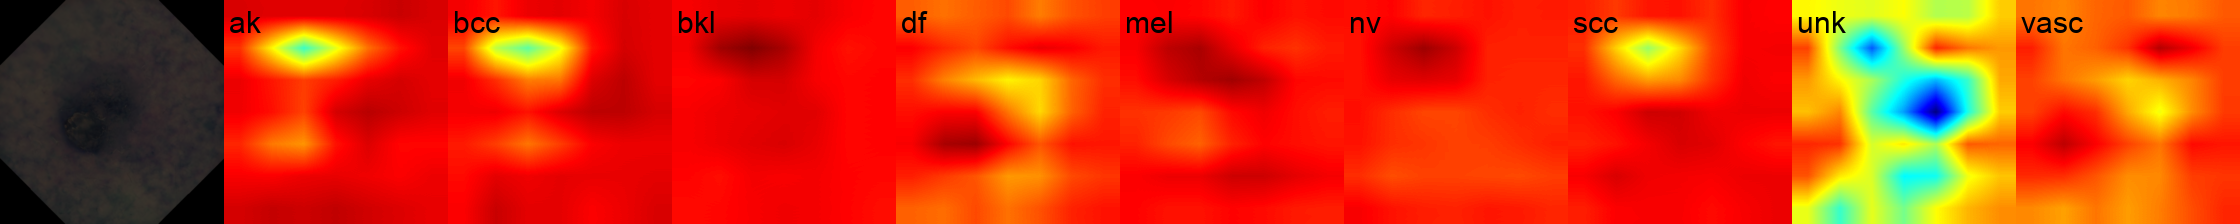

In [48]:


# generate heatmap
cam.display_random_heatmap(model, dl_train)



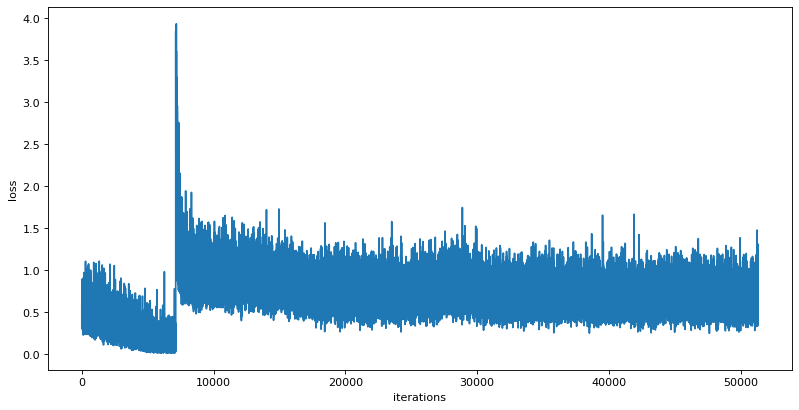

In [42]:

# create graph of loss
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(model_data['loss'])
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()





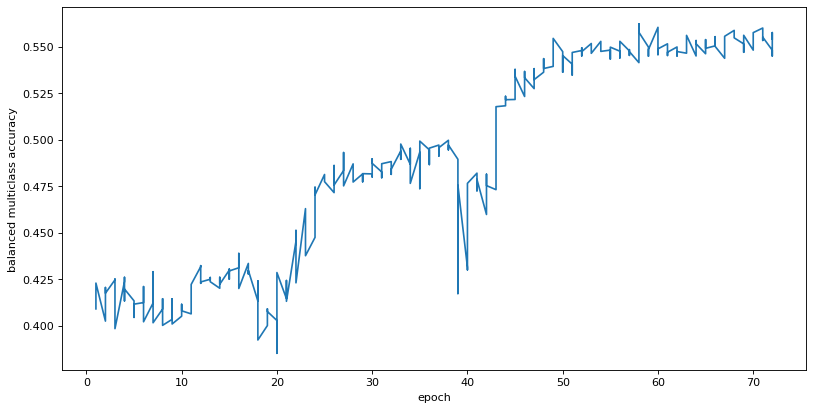

final balanced multi-class accuracy 0.5540860367660803


In [43]:

# print balanced multi-class accuracy (bma)

bma = d['validation_score']['balanced_multiclass_accuracy']
epochs = d['validation_score']['epoch']

fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(epochs, bma)
plt.ylabel('balanced multiclass accuracy')
plt.xlabel('epoch')
plt.show()

print('final balanced multi-class accuracy', bma[-1])

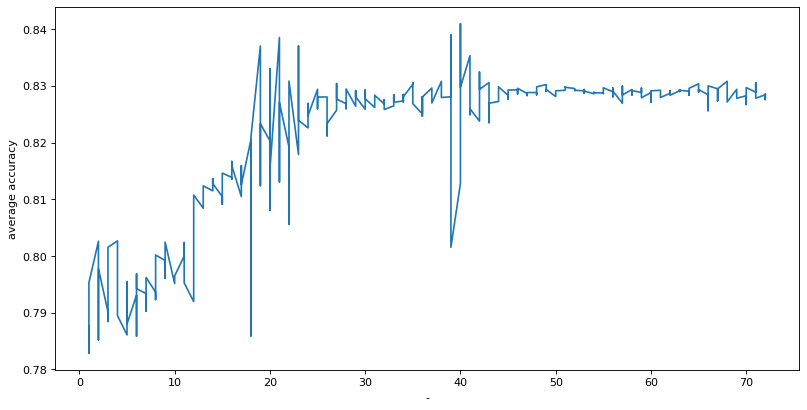

In [46]:

# plot Accuracy 

isic = (d['validation_score']['isic_score'])
epochs = d['validation_score']['epoch']

acc = []
for i in range(len(isic)):
  acc.append( (isic[i])['macro_average']['accuracy'] )

fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(epochs, acc)
plt.ylabel('average accuracy')
plt.xlabel('-')
plt.show()


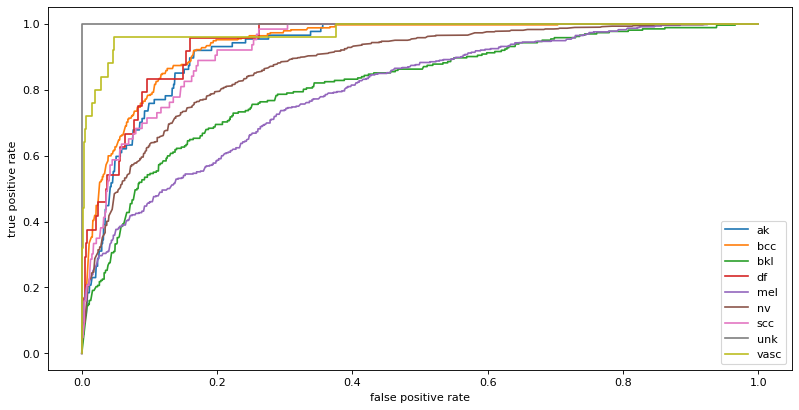

In [47]:

# plot ROCS
rocs = (isic[-1])['rocs']
fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
for label in rocs.keys():
  rocs[label]
  x = rocs[label]['fpr']
  y = rocs[label]['tpr']
  plt.plot(x,y, label=label )
  plt.ylabel('true positive rate')
  plt.xlabel('false positive rate')
plt.legend()
plt.show()
